load packages

In [28]:
from classes.AlexNet import AlexNet

import os

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load data

In [29]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Set path to MNIST data
mnist_path = os.path.join("..", "..", "data", "mnist-data")

training_data = datasets.MNIST(
    root=mnist_path,
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root=mnist_path,
    train=False,
    download=True,
    transform=transform
)

Example of the data

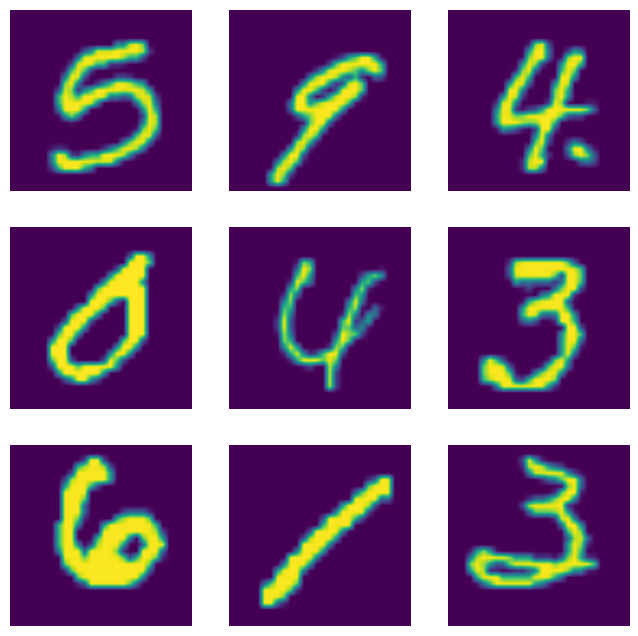

In [30]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]

    # Transpose the image to (224, 224, 3) from (3, 224, 224) for displaying with plt.imshow
    img = img.permute(1, 2, 0)

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

Create data loaders

In [31]:
batch_size = 500
train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size= batch_size, shuffle=True)

Define hyperparameters

In [32]:
num_classes = 10
num_epochs = 20
learning_rate = 0.002

model = AlexNet(num_classes).to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

Define training function

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

define test function

In [34]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


train and evaluate the model

In [35]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.302222  [  500/60000]
loss: 2.301687  [ 5500/60000]
loss: 2.302089  [10500/60000]
loss: 2.301066  [15500/60000]
loss: 2.301122  [20500/60000]
loss: 2.300752  [25500/60000]
loss: 2.300904  [30500/60000]
loss: 2.301371  [35500/60000]
loss: 2.300444  [40500/60000]
loss: 2.300544  [45500/60000]
loss: 2.299276  [50500/60000]
loss: 2.299811  [55500/60000]
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.298184 

Epoch 2
-------------------------------
loss: 2.300358  [  500/60000]
loss: 2.298621  [ 5500/60000]
loss: 2.299453  [10500/60000]
loss: 2.298179  [15500/60000]
loss: 2.295748  [20500/60000]
loss: 2.297005  [25500/60000]
loss: 2.295297  [30500/60000]
loss: 2.293548  [35500/60000]
loss: 2.292369  [40500/60000]
loss: 2.293147  [45500/60000]
loss: 2.289152  [50500/60000]
loss: 2.292109  [55500/60000]
Test Error: 
 Accuracy: 23.8%, Avg loss: 2.280524 

Epoch 3
-------------------------------
loss: 2.289078  [  500/60000]
loss: 2.279982  [ 5500/600

## Save model

In [36]:
import os

torch.save(model.state_dict(), os.path.join("..", "..", "data", "AlexNet", 'AlexNet_scratch_MNIST.pth'))